num of measurements = 1
Target Distribution: [0.  0.5 0.5 0. ]
Obtained Distribution: [0.0, 1.0, 0.0, 0.0]
Output Error (Manhattan Distance): 1.0
Parameters Found: [ 0.29356002  3.44508874  1.40939381  3.43370956 -4.91749958 -2.69055536
  3.4914783   5.8966215  -3.57746414  3.10972159]
num of measurements = 10
Target Distribution: [0.  0.5 0.5 0. ]
Obtained Distribution: [0.0, 0.5, 0.5, 0.0]
Output Error (Manhattan Distance): 0.39999999999999997
Parameters Found: [ 0.84435289  1.52913306 -0.84087715  0.2677619   1.10697547  0.39013914
  0.8147032   1.27972481  0.19845008 -0.62563748]
num of measurements = 100
Target Distribution: [0.  0.5 0.5 0. ]
Obtained Distribution: [0.0, 0.4, 0.6, 0.0]
Output Error (Manhattan Distance): 0.12000000000000004
Parameters Found: [ 0.21634202  0.78555446  0.21163258 -0.64030379  1.02206259  0.12909285
  0.94271077 -0.50130252  0.88709333 -1.16076018]
num of measurements = 1000
Target Distribution: [0.  0.5 0.5 0. ]
Obtained Distribution: [0.009, 0.492, 

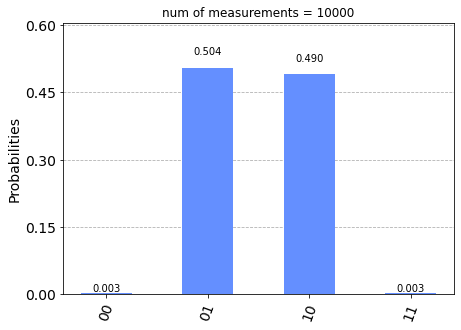

In [1]:
# Author: Han Liu
# Date: 09/20/2020

import numpy as np
import math
import sys
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister


# The target distribution
target_distr = np.array([0, 0.5, 0.5, 0])

# Initialize the number of layers and the number of parameters. 
num_layers=5
num_params=num_layers*2


##############Error model##########################
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

#Probabilities for the error model
p_m=0.001
p_g=0.001

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["rx"]) # single qubit gate error is applied to rx gates
    noise_model.add_all_qubit_quantum_error(error_gate1, ["ry"]) # single qubit gate error is applied to ry gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model
noise_model = get_noise(p_m,p_g)
###################################################






##################Ansatz circuit####################### 
def get_var_form(params,mes):
    if((num_layers < 1) or (len(params)!=num_params)): 
        print("Error!") 
        sys.exit(0)
    else:        
        circ = QuantumCircuit(2, 2)              
        k=0
        for iz in range (0, 2):
            circ.ry(params[k], iz)
            k=k+1
            
    i = 1        
    while i < num_layers:        
        if(i%2 == 0): 
            circ.cx(0, 1)
            #circ.cx(1, 0)
            for iz in range (0, 2):
                circ.ry(params[k], iz)
                k=k+1
        else:
            #circ.cx(1, 0)
            circ.cx(0, 1)
            for iz in range (0, 2):
                circ.ry(params[k], iz)
                k=k+1                
        i=i+1         
        
    if(mes==1):
        circ.measure([0,1], [0,1])    
    return circ
#######################################################
    
                

        
        
###############Get probability distribution ###########
def get_probability_distribution(counts):    

    if counts.get('00'):    
        pass
    else:
        counts["00"]=0
        
    if counts.get('11'):
        pass
    else:
        counts["11"]=0 
        
    if counts.get('01'):
        pass
    else:
        counts["01"]=0
        
    if counts.get('10'):
        pass
    else:
        counts["10"]=0
        
    #output_distr = [v / NUM_SHOTS for v in counts.values()]                       
    output_distr = [counts.get('00')/NUM_SHOTS,counts.get('01')/NUM_SHOTS,counts.get('10')/NUM_SHOTS,counts.get('11')/NUM_SHOTS]       
    return output_distr
#######################################################




##################Cost function########################
def objective_function(params):
    # Obtain a quantum circuit instance from the paramters
    circ = get_var_form(params,1)
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters, 
    # including the noise model
    result = execute(circ, backend, shots=NUM_SHOTS, noise_model=noise_model).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(circ))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(4)])
    return cost
######################################################



########################Main########################
#from qiskit import Aer, execute
from qiskit import Aer, execute

# Initialize the optimizer
from qiskit.aqua.components.optimizers import COBYLA, SPSA
backend = Aer.get_backend("qasm_simulator")
optimizer = SPSA(maxiter=500)
#optimizer = COBYLA(maxiter=500, tol=0.0001)

#set num of measurements/iteration
for i in range(0,5):

    NUM_SHOTS = 10**(i)

    # Create the initial parameters
    params = np.random.rand(num_params)

    # Optimization
    op = optimizer.optimize(num_vars=num_params, objective_function=objective_function, initial_point=params)

    # Obtain the output distribution using the final parameters
    circ = get_var_form(op[0],1)
    counts = execute(circ, backend, shots=NUM_SHOTS, noise_model=noise_model).result().get_counts(circ)
    output_distr = get_probability_distribution(counts)


    # Output
    print('num of measurements = %d'%(NUM_SHOTS))
    print("Target Distribution:", target_distr)
    print("Obtained Distribution:", output_distr)
    print("Output Error (Manhattan Distance):", op[1])
    print("Parameters Found:", op[0])        
    
  
#Draw the statevector: to show the coefficients of each states, for the Bonus part
#I found that it is relevant to the direction of CNOT I put between Ry layers. 
#If I only use CNOT from q0 to q1, 
#but not the other way around, or mixing, then I can always obtain a |01>+|10>.
####################################################################################
backend = Aer.get_backend('statevector_simulator')
circ = get_var_form(op[0],0)
state = execute(circ, backend).result().get_statevector()
print("num_layers, Qubit State = " + str(num_layers)+','+str(state))
#####################################################################################
    
    
plot_histogram(counts, title='num of measurements = %d'%(NUM_SHOTS)) 
###################################################